# Analyze Training Results

## Pre-Requisite: _You must run the previous notebook to generate debugger artifacts._

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
%store -r training_job_debugger_artifacts_path

In [3]:
try:
    training_job_debugger_artifacts_path
except NameError:
    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    print('[ERROR] Please wait for the previous notebook to finish.')
    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

In [4]:
print(training_job_debugger_artifacts_path)

s3://sagemaker-us-east-1-146478650644/tensorflow-training-2020-09-26-18-45-37-202/debug-output


# Analyze Tensors

Before getting to analysis, here are some notes on concepts being used in Debugger that help with analysis.
* **Trial** - object that is a center piece of Debugger API when it comes to getting access to tensors. It is a top level abstract that represents a single run of a training job. All tensors emitted by training job are associated with its trial.
* **Step** - object that represents next level of abstraction. In Debugger - step is a representation of a single batch of a training job. Each trial has multiple steps. Each tensor is associated with multiple steps - having a particular value at each of the steps.
* **Tensor** - object that represent actual tensor saved during training job. Note, a tensor can be a 1-D scaler, as well (ie. loss is stored as a scalar).

For more details on these concepts as well as on Debugger API in general (including examples) please refer to Debugger Analysis API documentation.

In [5]:
from smdebug.trials import create_trial

# this is where we create a Trial object that allows access to saved tensors
trial = create_trial(training_job_debugger_artifacts_path)

[2020-09-26 19:48:34.736 ip-172-16-33-1:29770 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-146478650644/tensorflow-training-2020-09-26-18-45-37-202/debug-output


In [6]:
for i in trial.tensor_names():
    print(i)

[2020-09-26 19:48:40.678 ip-172-16-33-1:29770 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-09-26 19:48:41.704 ip-172-16-33-1:29770 INFO trial.py:210] Loaded all steps
accuracy
batch
loss
size
val_accuracy
val_loss


In [7]:
import pandas as pd

def get_data(trial, tensor_name, batch_index, steps_range, mode):
    tensor = trial.tensor(tensor_name)
    vals = []
    for step_num in steps_range:
        val = tensor.value(step_num=step_num, mode=mode)[batch_index]
        vals.append(val)
    return pd.DataFrame(columns=['steps', tensor_name], data=list(zip(steps_range, vals)))

# Get Tensors

In [8]:
import time

steps = 0
while steps == 0:
    # trial.steps return all steps that have been downloaded by Debugger to date.
    # It doesn't represent all steps that are to be available once training job is complete -
    # it is a snapshot of a current state of the training job. If you call it after training job is done
    # you will get all tensors available at once.
    steps = trial.steps()
    print('Waiting for tensors to become available...')
    time.sleep(3)
print('\nDone')

print('Getting tensors...')
rendered_steps = []

# trial.loaded_all_steps is a way to keep monitoring for a state of a training job as seen by Debugger.
# When SageMaker completes training job Debugger, and trial, becomes aware of it.

loaded_all_steps = False
while not loaded_all_steps:
    loaded_all_steps = trial.loaded_all_steps
    steps = trial.steps()

print('Done!')

Waiting for tensors to become available...

Done
Getting tensors...
Done!


# Visualize Loss

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 199, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 399, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 599, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690]
    steps      loss
0       0  1.607568
1      10  1.598225
2      20  1.585707
3      30  1.567846
4      40  1.517011
..    ...       ...
68    650  2.117647
69    660  2.152561
70    670  2.159986
71    680  2.095364
72    690  2.117647

[73 rows x 2 columns]


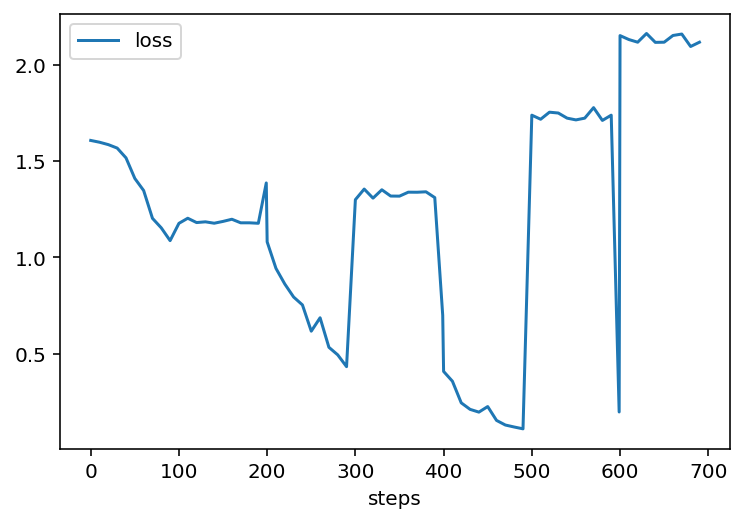

In [9]:
from smdebug.tensorflow import modes
import time

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

#from matplotlib import pyplot as plt

import pandas as pd

# Let's visualize weights of the first convolutional layer as they progressively change through training.
tensor_name = 'loss'

num_batches = trial.tensor(tensor_name).value(step_num=steps[0]).shape[0]
for batch_index in range(0, num_batches):
    steps_range = trial.tensor(tensor_name).steps()
    print(steps_range)
    data = get_data(trial=trial, 
                    tensor_name=tensor_name, 
                    batch_index=batch_index, 
                    steps_range=steps_range, 
                    mode=modes.GLOBAL)
    print(data)
    data.plot(x='steps', y=tensor_name)

# Visualize Accuracy

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 199, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 399, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 599, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690]
    steps  accuracy
0       0  0.218750
1      10  0.208097
2      20  0.235863
3      30  0.267641
4      40  0.288300
..    ...       ...
68    650  0.467218
69    660  0.467213
70    670  0.467320
71    680  0.467207
72    690  0.467119

[73 rows x 2 columns]


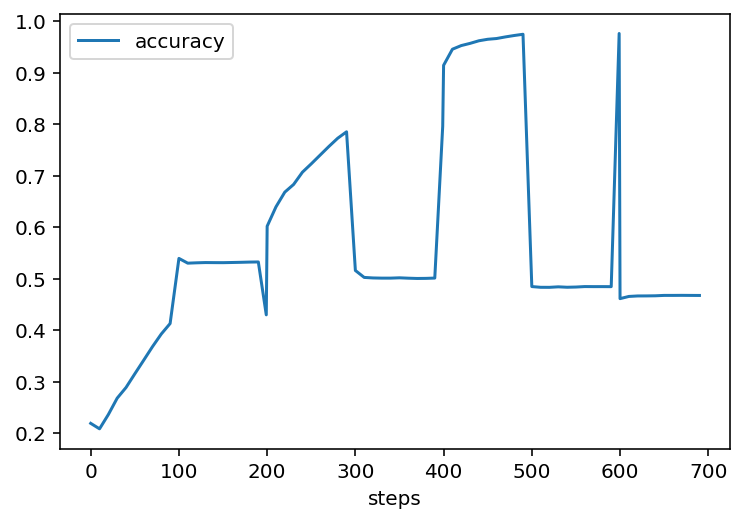

In [10]:
from smdebug.tensorflow import modes
import time

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd

tensor_name = 'accuracy'

num_batches = trial.tensor(tensor_name).value(step_num=steps[0]).shape[0]
for batch_index in range(0, num_batches):
    steps_range = trial.tensor(tensor_name).steps()
    print(steps_range)
    data = get_data(trial=trial, 
                    tensor_name=tensor_name, 
                    batch_index=batch_index, 
                    steps_range=steps_range, 
                    mode=modes.GLOBAL)
    print(data)
    data.plot(x='steps', y=tensor_name)

In [11]:
%%javascript
Jupyter.notebook.save_checkpoint();
Jupyter.notebook.session.delete();